# HybrIK: A Hybrid Analytical-Neural Inverse Kinematics Solution for 3D Human Pose and Shape Estimation
Paper link: https://arxiv.org/abs/2011.14672

Packages you need to install in addition to previous notebooks:

```bash
easydict
```

In [1]:
import torch
import numpy as np
from hybrik_model.SMPL import SMPL_layer, get_jts_29
import matplotlib.pyplot as plt

In [2]:
REGRESSOR_PATH = 'hybrik_model/J_regressor_h36m.npy'
SMPL_MODEL_PATH = 'parametric_models/smpl/SMPL_NEUTRAL.pkl'

J_regressor_h36m = torch.from_numpy(
                        np.load(REGRESSOR_PATH)
                    ).float()

hybrik_model = SMPL_layer(
    model_path=SMPL_MODEL_PATH,
    h36m_jregressor=J_regressor_h36m
)   
hybrik_model.shapedirs = hybrik_model.shapedirs[..., :10]

In [3]:
data = np.load('sample_smpl.npz')
print(list(data.keys()))

['trans', 'gender', 'mocap_framerate', 'betas', 'dmpls', 'poses']


In [4]:
poses = torch.from_numpy(data['poses']).float()
betas = torch.from_numpy(data['betas'])[:10].reshape(1, 10).repeat(poses.shape[0], 1).float()
trans = torch.from_numpy(data['trans']).float()

print('poses shape:', poses.shape)
print('betas shape:', betas.shape)
print('trans shape:', trans.shape)

poses shape: torch.Size([2733, 156])
betas shape: torch.Size([2733, 10])
trans shape: torch.Size([2733, 3])


In [5]:
# Forward kinematics
body_pose = torch.concatenate([poses[:, 3:66], torch.zeros(poses.shape[0], 6)], dim=1)
out = hybrik_model(
    global_orient=poses[:, :3],
    pose_axis_angle=body_pose,
    betas=betas,
    transl=trans
)

vertices = out.vertices
joints_29 = get_jts_29(out.vertices, out.joints)
joints_from_verts = out.joints_from_verts

twist_angle = out.twist_angle
phis = out.phis


print('vertices shape:', vertices.shape)
print('joints_29 shape:', joints_29.shape)
print('joints_from_verts shape:', joints_from_verts.shape)
print('twist_angle shape:', twist_angle.shape)
print('phis shape:', phis.shape)

vertices shape: torch.Size([2733, 6890, 3])
joints_29 shape: torch.Size([2733, 29, 3])
joints_from_verts shape: torch.Size([2733, 17, 3])
twist_angle shape: torch.Size([2733, 23, 1])
phis shape: torch.Size([2733, 23, 2])


In [6]:
def visualize(points, point_size=1, parents=None, colors=None):
    # Drop batch dimension
    pts = points[0].detach().cpu().numpy()

    x = pts[:, 0]
    y = pts[:, 1]
    z = pts[:, 2]

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z, s=point_size, c=colors, cmap='tab20')

    # Optionally draw bones from i -> parents[i]
    if parents is not None:
        parents = parents.numpy()

        for child_idx, parent_idx in enumerate(parents):
            if parent_idx == -1:
                continue
            ax.plot([x[child_idx], x[parent_idx]],
                    [y[child_idx], y[parent_idx]],
                    [z[child_idx], z[parent_idx]])


    max_range = np.array([
        x.max() - x.min(),
        y.max() - y.min(),
        z.max() - z.min()
    ]).max()

    mid_x = 0.5 * (x.max() + x.min())
    mid_y = 0.5 * (y.max() + y.min())
    mid_z = 0.5 * (z.max() + z.min())

    ax.set_xlim(mid_x - max_range/2, mid_x + max_range/2)
    ax.set_ylim(mid_y - max_range/2, mid_y + max_range/2)
    ax.set_zlim(mid_z - max_range/2, mid_z + max_range/2)

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

    # Make it y-up (your original view)
    # ax.view_init(elev=120, azim=-90)

    plt.show()

/tmp/ipykernel_269080/3991479330.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, z, s=point_size, c=colors, cmap='tab20')


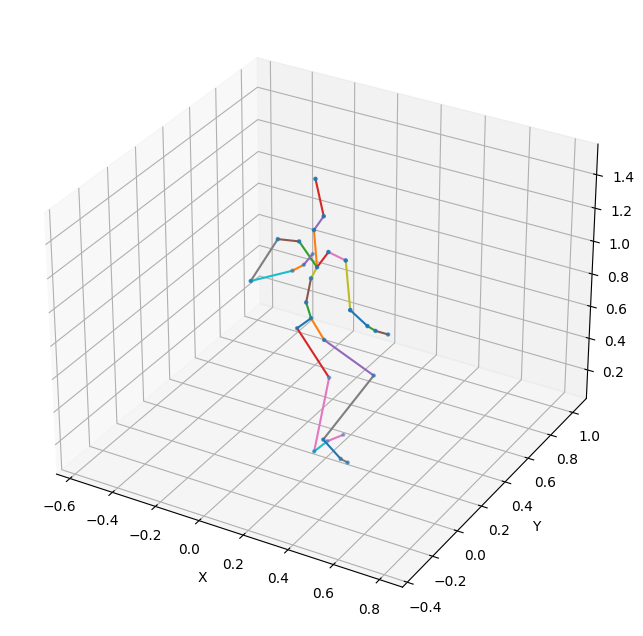

In [7]:
joints_29_firstframe = joints_29[0:1] 
phis_first_frame = phis[0:1]
    
visualize(joints_29_firstframe, point_size=5, parents=hybrik_model.parents)

Let's manually adjust some keypoints

/tmp/ipykernel_269080/3991479330.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, z, s=point_size, c=colors, cmap='tab20')


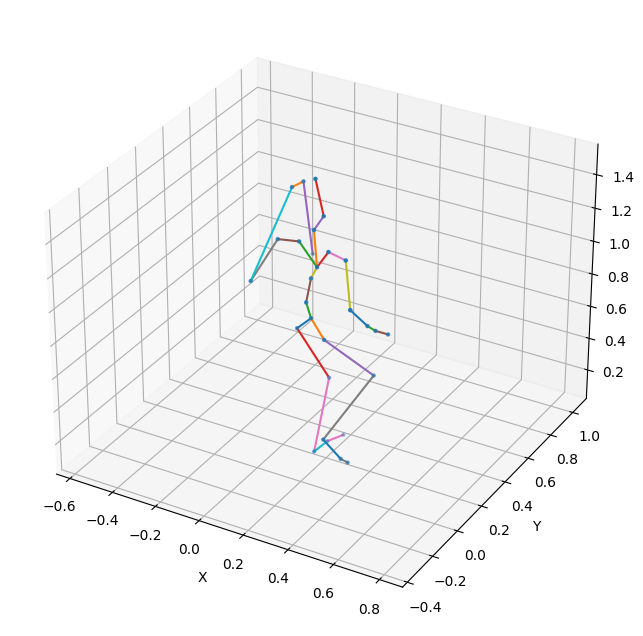

In [8]:
joints_29_firstframe[0, 20] += torch.tensor([0.0, 0.0, 0.5])  
joints_29_firstframe[0, 22] += torch.tensor([0.0, 0.0, 0.5])
visualize(joints_29_firstframe, point_size=5, parents=hybrik_model.parents)

In [9]:
out_ik = hybrik_model.hybrik(pose_skeleton=joints_29_firstframe,
                             phis=phis_first_frame,
                             betas=betas[0:1],
                             global_orient=None)
joints_ik = get_jts_29(out_ik.vertices, out_ik.joints)

/tmp/ipykernel_269080/3991479330.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, z, s=point_size, c=colors, cmap='tab20')


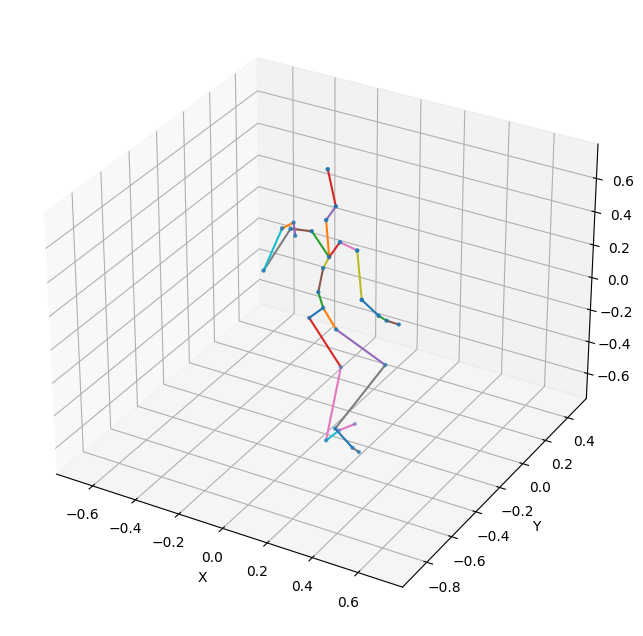

In [10]:
visualize(joints_ik, point_size=5, parents=hybrik_model.parents)